# 時系列分析

この演習では，Facebook社が開発した [prophet](https://facebook.github.io/prophet/) という強力なライブラリを用いて，手軽にかつ効果的な時系列分析を体験します．
この演習で用いるデータは以下の通りです：

* ある航空会社の利用者数
* 自転車シェアリングサービスDivvyの利用者数

演習に先立って，必要なライブラリを読み込んでおきます．
以下のコードをGoogle Colaboratoryに貼り付けて実行してください．

In [1]:
import math
import numpy as np
import pandas as pd
from fbprophet import Prophet
#from fbprophet.plot import add_changepoints_to_plot

from matplotlib import pyplot as plt
%matplotlib inline

---

## 例題1: ある航空会社の利用者数

以下のURLにあるファイル`air_passengers.csv`には，ある航空会社の利用者数が日付別に格納されています．このデータを使って，利用者数の時系列分析を行ってみましょう．

まずは，以下のコードでデータをダウンロードし，`pandas`のデータフレーム形式でデータを格納します．

In [2]:
# データの読み込み
url = "http://drive.hontolab.org/ymc-lecture2020/data/air_passengers.csv"
_passengers_df = pd.read_csv(url, index_col='Month', parse_dates=True, dtype='float')

# 最初の5件を表示
_passengers_df.head()

,#Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


上記データがどのような時間変化をしているのか，いったんデータを可視化してみましょう．何も考えずに，下記コードを実行してみてください．

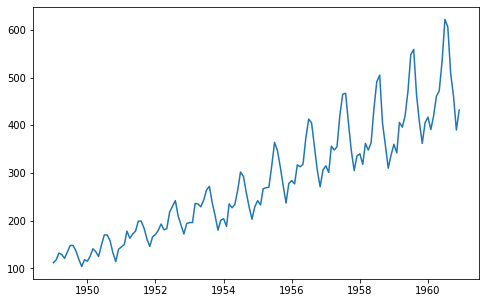

In [3]:
plt.figure(figsize=(8.0, 5.0))
plt.plot(_passengers_df['#Passengers'])

グラフを見ると，周期性があることがうかがえます．早速，Prophetライブラリを用いて，ページ閲覧数を時系列モデリングしてみましょう．Prophetは，以下の2つの列を含むデータフレームを入力として受け付けます．

* ds: データの生成日時
* y: データの生成日時に対応した目的変数（数値データ）

先ほど読み込んだ`_passengers_df`は上記形式のデータフレームではない（列名が異なる）ので，Prophet用に列名を変更します．以下のコードを実行して，変更を加えたデータフレームを`passengers_df`とします．


In [4]:
# データの列名を修正
passengers_df = _passengers_df.reset_index(
).rename(
    columns={
        'Month': 'ds',
        '#Passengers': 'y'
    }
)

# 列名が変更されたか確認
passengers_df.tail()

,ds,y
139,1960-08-01,606.0
140,1960-09-01,508.0
141,1960-10-01,461.0
142,1960-11-01,390.0
143,1960-12-01,432.0


これでProphetを用いて時系列モデリングが始められます．以下のコードを走らせてみてください．

In [5]:
# Prophetクラスを初期化
model = Prophet()

# 時系列モデリングを実行
model.fit(passengers_df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


これで時系列モデリングが完了しました！Prophetライブラリは，デフォルトの状態でも
* トレンド
* 曜日（weekly）周期性
* 月（monthly）周期性

を考慮した時系列モデリングを高精度に行ってくれます．

時系列モデリングの醍醐味は「将来の予想」です．もし，入手したデータの背後にある時系列モデルが変化しないと仮定したときの，1960年末から1年後の利用者数を予測してみましょう．

予測のために，まず，手持ちのデータの最終日時から1年後までの間の時刻だけ入ったデータフレーム`future_df`を作成します．以下のコードを実行してください．

In [6]:
# 最後のデータから365日後までの，時刻だけ入ったデータフレームを作成
future_df = model.make_future_dataframe(periods=365)

# データの末尾だけ表示
future_df.tail()

,ds
504,1961-11-27
505,1961-11-28
506,1961-11-29
507,1961-11-30
508,1961-12-01


この時刻だけ入ったデータフレームに先ほど構築した時系列モデルを適用して，将来のページ閲覧数を予測します．予測も非常に簡単です．`sklearn`ライブラリと同じように，`model.predict`とすれば予測結果が得られます．

In [7]:
# 予測
forecast_df = model.predict(future_df)

# 結果の末尾5件を表示
forecast_df.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
504,1961-11-27,521.263765,471.651223,527.698196,520.661679,521.832559,-21.334440,-21.334440,-21.334440,-21.334440,-21.334440,-21.334440,0.0,0.0,0.0,499.929324
505,1961-11-28,521.364769,469.193593,526.863898,520.760625,521.936005,-23.039528,-23.039528,-23.039528,-23.039528,-23.039528,-23.039528,0.0,0.0,0.0,498.325242
506,1961-11-29,521.465774,465.930148,523.572553,520.859572,522.039451,-25.468646,-25.468646,-25.468646,-25.468646,-25.468646,-25.468646,0.0,0.0,0.0,495.997128
507,1961-11-30,521.566779,463.817967,523.031738,520.958518,522.142897,-28.580334,-28.580334,-28.580334,-28.580334,-28.580334,-28.580334,0.0,0.0,0.0,492.986445
508,1961-12-01,521.667783,459.027336,517.363186,521.056788,522.246343,-32.315328,-32.315328,-32.315328,-32.315328,-32.315328,-32.315328,0.0,0.0,0.0,489.352455


予測結果が得られました．`forecast_df`にはたくさんの情報が入っていますが，最終的な予測結果のみを確認するには，以下のようにします．

In [8]:
forecast_df[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
504,1961-11-27,499.929324,471.651223,527.698196
505,1961-11-28,498.325242,469.193593,526.863898
506,1961-11-29,495.997128,465.930148,523.572553
507,1961-11-30,492.986445,463.817967,523.031738
508,1961-12-01,489.352455,459.027336,517.363186


`yhat`が予測値の平均値になります．`yhat_lower`，`yhat_upper`は予測値の95%信頼区間の上限，下限を示してみます．数値だけ見てもイメージが湧きづらいかと思いますので，以下のコードで予測結果を可視化してみましょう．

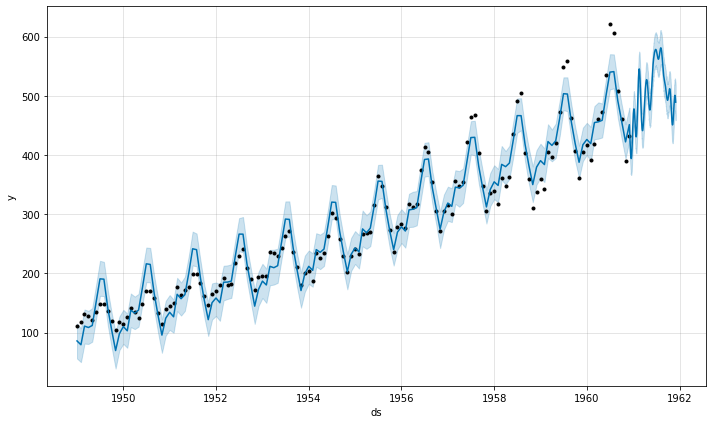

In [9]:
fig = model.plot(forecast_df)

それっぽい結果が出力されました．黒い点は実際のデータです．濃い青い線は予測値，薄い青色は信頼区間です．1960年末から1962年にかけてはデータがありませんので，完全な予測値となります．

これで予測が完了したのですが，構築された時系列モデルがどのように構成されているのかを知ることで，さらなる考察が可能となります．
以下のコードを実行して，時系列モデルの「トレンド」や「周期成分」を確認してみましょう．

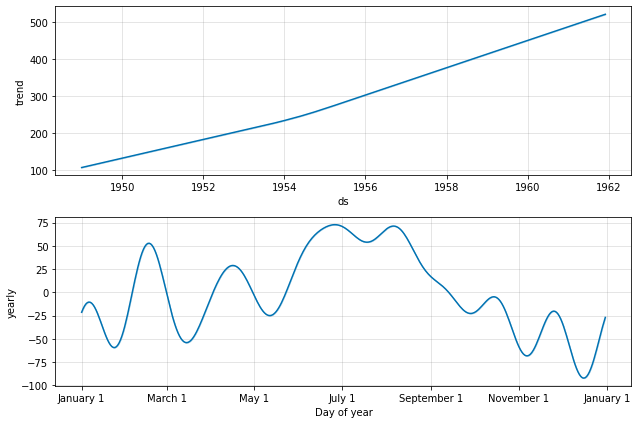

In [10]:
component_figs = model.plot_components(forecast_df)

1つ目の図が「トレンド」，2つ目の図が「季節変動」を示しています．

「トレンド」は右肩上がりの直線となっています．これは，全体的な傾向として，時間が経過するほど利用客が増えて行っていることを示唆しています．

「季節変動」の図は曲がりくねっていますが，利用客数が増える時期と減る時期があることが示唆されています．図からは，7月から8月頃が利用のピークで，そこから年末にかけて利用客が減っていくことがうかがえます．

これらの要素が合わさることで，最終的に利用客の予想値が決まることになります．

---
## 例題2: Divvyのサービス需要

もう少し複雑なデータの例を扱いましょう．次の例題では，米国はシカゴの自転車シェアリングサービス[Divvy](https://www.divvybikes.com/)のサービス需要予測を行ってみましょう．

[ここ](https://www.divvybikes.com/system-data)に過去の利用履歴データがまとめられているのですが，それらデータを加工して，日ごとにサービス利用者（自転車レンタル者）数を集計したファイルを作成しておきました．以下のコードを実行して，データを`_divvy_df`に格納しましょう．

In [11]:
# データの読み込み
url = "http://drive.hontolab.org/ymc-lecture2020/data/divvy.csv"
_divvy_df = pd.read_table(url, header=0, sep=",", index_col='date', parse_dates=True)

# 気温（temperature）が華氏（F）形式になっているので摂氏（C）に変換
_divvy_df['temperature'] = (_divvy_df['temperature'] - 32) * 5 / 9

# 先頭5件のみ表示
_divvy_df.head()

,weather,rides,temperature
date,,,
2014-01-01,rain or snow,95,-6.953801
2014-01-02,rain or snow,111,-8.425926
2014-01-03,cloudy,6,-20.907407
2014-01-04,rain or snow,181,-1.106814
2014-01-05,rain or snow,32,-8.468750


データが読み込めました．今回の課題で予測できるようにしたいのは`rides`（サービス利用者数）です．時系列モデルを構築する前に，時間とともに`rides`がどう変化してきたか，確認してみましょう．可視化は以下のコードで行います．

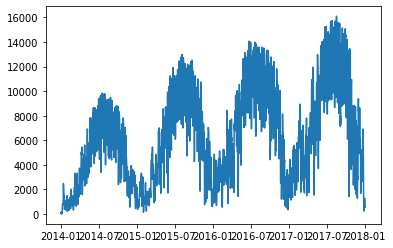

In [12]:
plt.plot(_divvy_df['rides'])
plt.show()

周期性はあるようですが，全体の傾向としては利用者が増加していっているように見えます．サービス提供者側としては，できるだけ正確に利用者数を予想したくなります．Divvyは自転車シェアリングサービスですから，その日の気温や天気によって利用者数は大きく変わりそうです．これら要素も含めて時系列モデリングができたら，利用者数予測に大いに役立ちそうです．それでは，Prophetを使って分析してみましょう．

まずはProphetを利用するために，データをProphetに都合のよい形式に変換しましょう．Prophetは
* データ生成日時は`ds`
* 予測したい目的変数を`y`

としたデータフレームを入力として受け付けます．また，天気のようなカテゴリ変数は「数値」として扱えるようにしておくのが望ましいです．今回は何も考えずに，以下のコードを実行してデータを変換してください．

In [13]:
divvy_df = _divvy_df.reset_index(
).rename( # 列名を変更
    columns = {
        'date': 'ds',
        'rides': 'y' # ridesをyに変換
    }
).pipe( # weatherの内容をダミー変数に変換
    lambda df: pd.concat([df, pd.get_dummies(df['weather'], drop_first=True)], axis=1)
).drop(
    'weather', axis=1
)

# 先頭5件を表示
divvy_df.head()

,ds,y,temperature,cloudy,not clear,rain or snow
0,2014-01-01,95,-6.953801,0,0,1
1,2014-01-02,111,-8.425926,0,0,1
2,2014-01-03,6,-20.907407,1,0,0
3,2014-01-04,181,-1.106814,0,0,1
4,2014-01-05,32,-8.468750,0,0,1


変換ができました．`cloudy`，`not clear`，`rain or snow`列が天気を表しています．`cloudy`が1の場合，その日は「曇り」だったことを意味します．`not clear`は「少し曇っている」を意味します．`cloudy`，`not clear`，`rain or snow`のすべてが0の場合は「晴れ」を意味します．

今回の分析は，「もし天気が雨で気温が低い場合は利用者数はどうなるだろう？」といったように，時間だけでなく外因性（環境要因やイベントなど）も考慮した時系列モデリングを行います．利用者数をシミュレーションするためには，仮想的な気温や天気の設定が必要となります．ですので，`divvy_df`の最後の1年間のデータを仮想的な間引いたデータを時系列モデルの構築に使いましょう．

それでは例題1と同様にProphetを走らせてみましょう．

In [14]:
# Prophetクラスのインスタンスを準備
model = Prophet()

# 2017年1月1日以前のデータをモデル構築のために利用する
train_df = divvy_df[divvy_df['ds'] < pd.to_datetime('2017-01-01')]

# 時系列モデリングを実行 
model.fit(train_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


統計モデルを構築しましたので，未来をシミュレーションをしてみましょう．例題1と同様に，`make_future_dataframe`メソッドを使って，シミュレーション用のデータを作成します．

In [15]:
# 2017年1月1日以降のシミュレーションを行うのためのデータ作り
future = model.make_future_dataframe(periods=365, freq='d')

# 予測させたいデータの末尾5件を表示
future.tail()

,ds
1453,2017-12-27
1454,2017-12-28
1455,2017-12-29
1456,2017-12-30
1457,2017-12-31


それではシミュレーション用のデータに時系列モデルを適用して，将来予測をしてみましょう．以下のコードを実行します．

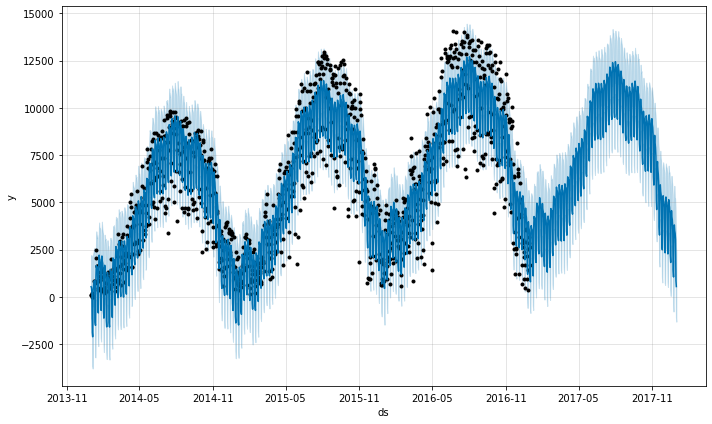

In [16]:
# 予測を実行
forecast = model.predict(future)

# 予測結果の可視化
fig = model.plot(forecast)

うまく予測できているように見えます．時系列モデルの構造を調べてみましょう．例題1と同様に，`plot_components`メソッドを利用します．

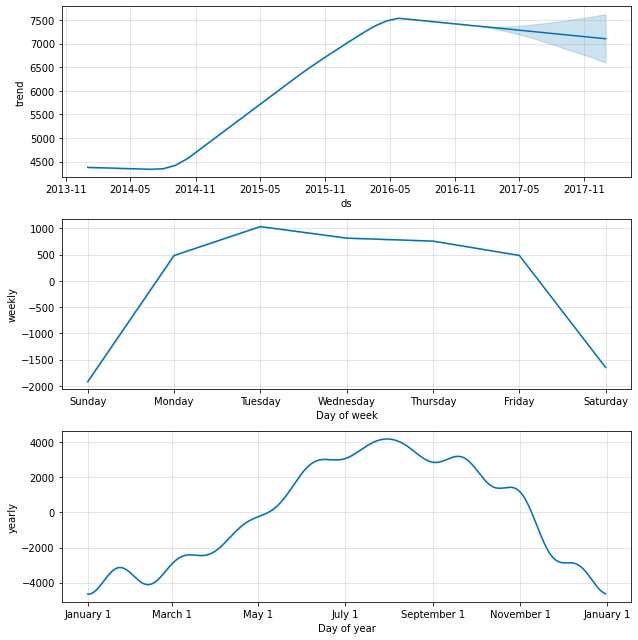

In [17]:
fig2 = model.plot_components(forecast)

時系列モデルの構造を確認すると，以下のようなことが分かります：
* 2014年8月頃から利用者数は上昇傾向となったが，2016年5月くらいから横ばいになりつつあること
* 平日の利用者が多く，土日は利用者が少ないこと
* 1年を通じて8月，9月が利用のピークであること

さて，今回構築した時系列モデルは「気温」や「天気」を考慮しておらず，時間と利用者数の関係のみを分析していました．例題の最初で述べたように，利用者数は「気温」や「天気」に強く依存していると思われます．また，平日と土日で利用者数に差があるとすると，祝日も影響することが考えられます．

では，「気温」や「天気」，「祝日」を考慮した時系列モデリングをやってみましょう．まずはシミュレーション用のデータを作成します．`make_future_dataframe`メソッドで作成した`future`偏すには時間情報しか入っていませんでした．ここに，仮想的な「気温」「天気」の情報を付加しましょう．以下のコードを実行してください．

In [18]:
# シミュレーション用のデータに気温や天気の情報を加える
future['temperature'] = divvy_df['temperature']
future['cloudy'] = divvy_df['cloudy']
future['not clear'] = divvy_df['not clear']
future['rain or snow'] = divvy_df['rain or snow']

次にProphetクラスのインスタンスの追加設定を行います．以下のコードを実行してください．

In [19]:
# Prophetクラスのインスタンスを準備
model = Prophet()

# 国民の祝日を考慮するように設定
model.add_country_holidays(country_name='US')

# 'temperature'の属性を考慮するよう設定
model.add_regressor('temperature')

# 'cloudy（天気）'の属性を考慮するよう設定
model.add_regressor('cloudy')

# 'not clear（天気）'の属性を考慮するよう設定
model.add_regressor('not clear')

# 'rain or snow（天気）'の属性を考慮するよう設定
model.add_regressor('rain or snow')

これで追加属性を考慮した時系列モデリングをする準備が届きました．あとは，これまでの手順と一緒です．以下のコードを実行して，モデリングを行いましょう．

In [20]:
# 2017年1月1日以前のデータをモデル構築のために利用する
train_df = divvy_df[divvy_df['ds'] < pd.to_datetime('2017-01-01')]

# 時系列モデリングを実行 
model.fit(train_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


では，将来予測結果と時系列モデルの構造を可視化してみましょう．

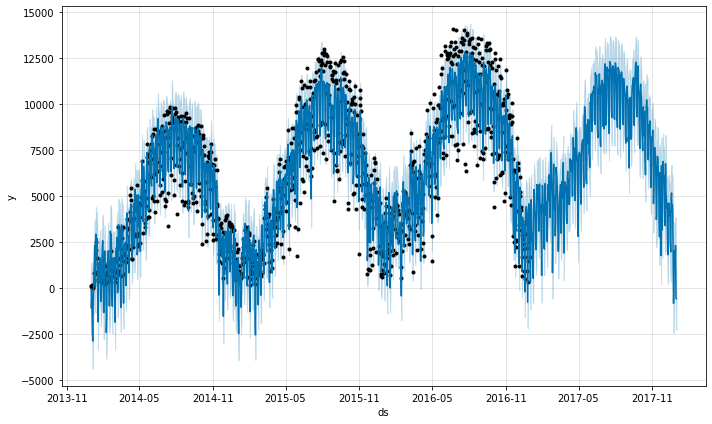

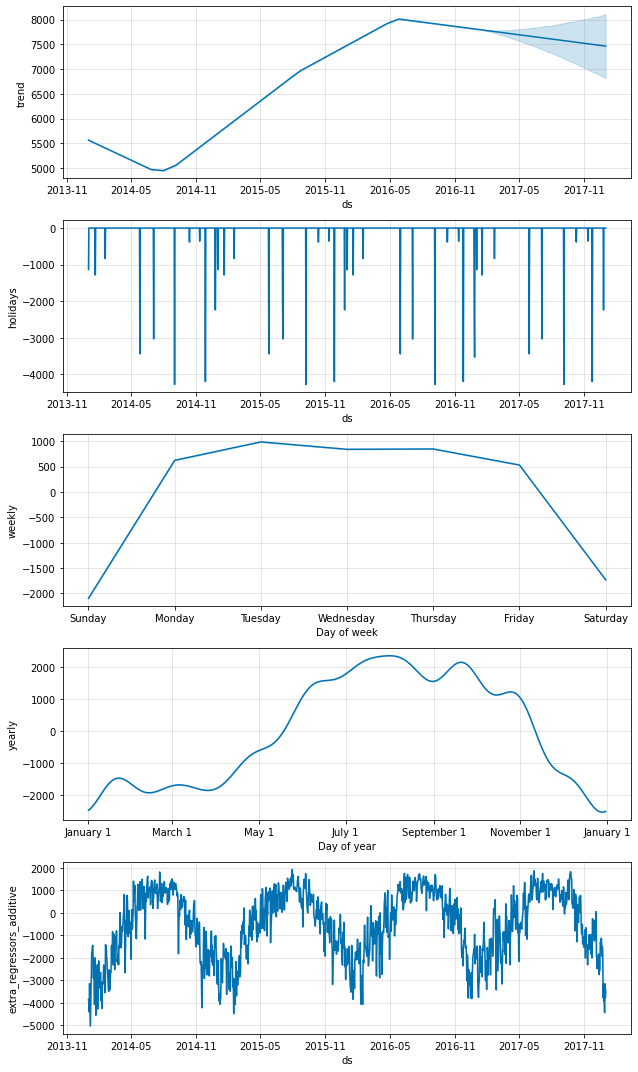

In [21]:
# 予測を実行
forecast = model.predict(future)

# 予測結果の可視化
fig = model.plot(forecast)

# 時系列モデルの構造を可視化
fig2 = model.plot_components(forecast)

外部要因を加えた時系列モデルの構造が可視化されました．以前の結果との違いとして，まず`holidays`グラフが追加されています．これは休日指定した場合，その休日がどの程度利用者数の増減に影響したかを示しています．休日によって差はあるものの，休日は利用者数が減ることが分かります．

`extra_regressors_additive`という名前のグラフも追加されています．これは`add_regressor`メソッドで追加した休日以外の外部要因（気温や天気）の総合的な影響度を表しています．追加した外部要因が1つであれば，このグラフで十分に考察ができます．しかし，今回は複数の外部要因を追加していますので，このグラフでは気温や天気の影響を個別に考察することができません．少し工夫を凝らします．


prophetの時系列モデリングでは，気温などの外部要因をモデルに追加したときは，

$予想したい値 = ... + \beta_{気温} * 気温$

といったように，何らかの **重みを掛け合わせた足し算（線形要素）** としてその影響を加味します．prophetの予測結果（これまでの例では`forecast`）には，各要因ごとの予測成分（例: $\beta_{気温}*気温$）が格納されています．

`forecast`の中身の一部を見てみましょう．以下のコードを実行します．

In [22]:
forecast[['ds', 'temperature']].tail()

,ds,temperature
1453,2017-12-27,-3354.391232
1454,2017-12-28,-2794.884004
1455,2017-12-29,-2648.973965
1456,2017-12-30,-3273.998112
1457,2017-12-31,-2938.744059


上の表で`temperature`は「気温要因の重要度 × 気温（つまり$\beta_{気温}*気温$）」を意味しています．外部要因の重要度を調べたい場合は，予測成分（例：$\beta_{気温}*気温$）を元の要因の値（例：気温）で割ることで要因の重要度（例：$\beta_{気温}$）を求めることができます．

$\beta$の計算は少し複雑になりますが，以下のコードを実行することで$\beta$の平均値を求めることができます．

In [23]:
beta_df = forecast.rename(
  columns = {
      'temperature': 'temperature_effect',
      'rain or snow': 'rain_effect',
      'cloudy': 'cloudy_effect',
      'not clear': 'not_clear_effect'
  } 
).merge(
    future, on='ds'
).assign(
    temp_beta = lambda df: df['temperature_effect'] / df['temperature'],
    rain_beta = lambda df: df['rain_effect'] / df['rain or snow'],
    cloudy_beta = lambda df: df['cloudy_effect'] / df['cloudy'],
    not_clear_beta = lambda df: df['not_clear_effect'] / df['not clear']
)[['ds', 'temp_beta', 'rain_beta', 'cloudy_beta', 'not_clear_beta']]

# betaの平均値を求める
beta_df.mean()

<ipython-input-23-6be4e1a29b96>:18: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  beta_df.mean()


temp_beta          130.144709
rain_beta        -1638.361970
cloudy_beta       -504.458059
not_clear_beta    -200.353265
dtype: float64

外部要因の影響度を求めることができました．上記結果によると，`temp_beta`は130となっています．これは「気温が華氏1度上がると利用者数が130程度アップする」ことを示唆しています．同様に，`rain_beta`は「雨が降ると利用者数が1638程度ダウンする」ことを示唆しています．この予測モデルを用いれば，仮に「将来XX年YY月ZZ日に雨が降ったとしたら，利用者数は何人になるか」といった予想を行うことが可能になります．

これでProphetの体験は終了です．従来，時系列分析は難解な統計モデルを組む必要がありました．Prophetは統計モデリングの知識がほとんどなくても，考慮したい要因さえはっきりしていれば，簡単に比較的高精度の予測モデルを作ることができます．